# Classification Trees and Random Forest Classification (supermarket data)

In this notebook, we will use Classification Tree and Random Forest classifiers to predict supermarket brands based on various features like location, population density, brand, and more. We will evaluate the models using feature importance, confusion matrices, and ROC curves.

## Libraries and settings

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn import tree
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/workspaces/python_machine_learning_basics/CART_RandomForest


## Import supermarkets data

In [2]:
# Read and select variables
columns = ['id',
           'bfs_name',
           'bfs_number',
           'lat',
           'lon',
           'brand',
           'pop',
           'pop_dens',
           'frg_pct',
           'emp',
          ]
df_supermarkets_orig = pd.read_csv("./Data/supermarkets_data_enriched.csv", 
                                   sep=",", 
                                   encoding="utf-8")[columns]

# Number of rows and columns
print(df_supermarkets_orig.shape)

# Brand to upper case letters
df_supermarkets_orig['brand'] = df_supermarkets_orig['brand'].str.upper()

# First records
df_supermarkets_orig.head(5)

(3242, 10)


,id,bfs_name,bfs_number,lat,lon,brand,pop,pop_dens,frg_pct,emp
0,33126515,Schänis,3315,47.155616,9.037915,SPAR,3876,97.142857,13.054696,1408.0
1,280130028,Schänis,3315,47.155492,9.039666,ALDI,3876,97.142857,13.054696,1408.0
2,6122906632,Schänis,3315,47.158959,9.044477,DENNER,3876,97.142857,13.054696,1408.0
3,9019298862,Schänis,3315,47.155185,9.038472,LIDL,3876,97.142857,13.054696,1408.0
4,36726161,Uznach,3339,47.226191,8.980329,MIGROS,6489,860.610080,27.862537,3500.0


## Count and remove missing values

In [3]:
# Count missing values
print(df_supermarkets_orig.isna().sum())

# Remove missing values
df_supermarkets = df_supermarkets_orig.dropna()
df_supermarkets

id               0
bfs_name         0
bfs_number       0
lat              0
lon              0
brand         1233
pop              0
pop_dens         0
frg_pct          0
emp             45
dtype: int64


,id,bfs_name,bfs_number,lat,lon,brand,pop,pop_dens,frg_pct,emp
0,33126515,Schänis,3315,47.155616,9.037915,SPAR,3876,97.142857,13.054696,1408.0
1,280130028,Schänis,3315,47.155492,9.039666,ALDI,3876,97.142857,13.054696,1408.0
2,6122906632,Schänis,3315,47.158959,9.044477,DENNER,3876,97.142857,13.054696,1408.0
3,9019298862,Schänis,3315,47.155185,9.038472,LIDL,3876,97.142857,13.054696,1408.0
4,36726161,Uznach,3339,47.226191,8.980329,MIGROS,6489,860.610080,27.862537,3500.0
...,...,...,...,...,...,...,...,...,...,...
3230,9584570723,Seedorf (UR),1214,46.881529,8.615975,VOLG,2051,106.379668,6.972209,703.0
3231,9593770082,Bäretswil,111,47.339296,8.839173,VOLG,5053,227.715187,10.152385,1647.0
3233,9624205242,Buch am Irchel,24,47.549645,8.618709,VOLG,979,95.886386,7.252298,200.0
3238,9950926547,Marbach (SG),3253,47.392404,9.569855,VOLG,2110,481.735160,18.578199,678.0


## Subset with selected brands

In [4]:
df_sub = df_supermarkets.loc[df_supermarkets['brand'].isin(['COOP', 'DENNER'])]
print(df_sub.shape)
df_sub.head()

(904, 10)


,id,bfs_name,bfs_number,lat,lon,brand,pop,pop_dens,frg_pct,emp
2,6122906632,Schänis,3315,47.158959,9.044477,DENNER,3876,97.142857,13.054696,1408.0
5,39768209,Uznach,3339,47.225069,8.969981,COOP,6489,860.610080,27.862537,3500.0
6,7389830915,Uznach,3339,47.225056,8.970650,DENNER,6489,860.610080,27.862537,3500.0
7,39947904,Zürich,261,47.376732,8.542161,COOP,420217,4778.994655,32.458468,491193.0
10,79977755,Zürich,261,47.340070,8.530546,COOP,420217,4778.994655,32.458468,491193.0


## Pivot table

In [5]:
# Berechnung des arith. Mittelwerts aller Werte (Summe aller Werte / Anzahl der Werte)
# lat = Breitengrad, lon = Längengrad, pop = Bevölkerung, pop_dens = Bevölkerungsdichte, 
# frg_pct = Ausländeranteil, emp = Beschäftigte

# Using pivot_table to reshape the data and calculate means 
pd.pivot_table(df_sub[['lat',
                       'lon',
                       'brand',
                       'pop',
                       'pop_dens',
                       'frg_pct',
                       'emp']],
                index=['brand'],
                values=['lat', 'lon', 'pop', 'pop_dens', 'frg_pct', 'emp'],
                aggfunc=(np.mean, 'count')).round(0)

emp          frg_pct         lat         lon        pop           \
       count     mean   count  mean count  mean count mean count     mean   
brand                                                                       
COOP     490  59281.0     490  27.0   490  47.0   490  8.0   490  56931.0   
DENNER   414  42229.0     414  27.0   414  47.0   414  8.0   414  43442.0   

       pop_dens          
          count    mean  
brand                    
COOP        490  2019.0  
DENNER      414  1855.0

## Classification Tree
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [6]:
# Aufteilung in 2 Teile: nabhängigen Variablen (Features) und die abhängige Variable (Zielvariable)
# unabhänige Variablen: lat, lon, pop, pop_dens, frg_pct, emp
# train_test_split & test_size: Aufteilung in 80% Trainings- und 20% Testdaten
# random_state: Zufallszahlengenerator 42 reproduzierbar

# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_sub[['lat',
                                                            'lon',
                                                            'pop', 
                                                            'pop_dens', 
                                                            'frg_pct', 
                                                            'emp']],
                                                    df_sub['brand'], 
                                                    test_size=0.20, 
                                                    random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
            lat       lon     pop     pop_dens    frg_pct       emp
32    47.393648  8.529543  420217  4778.994655  32.458468  491193.0
2978  46.610555  7.063649   23871  1000.461023  40.970215   15622.0
1258  46.175455  8.887311   15776   844.087747  34.248225   13188.0
2902  47.422573  8.370296   12065  1402.906977  50.269374    8342.0
2763  47.229717  9.023207    5218   155.343852  13.089306    1408.0 

y_train:
32        COOP
2978    DENNER
1258    DENNER
2902    DENNER
2763    DENNER
Name: brand, dtype: object


### Fit the classification tree model and make predictions

In [7]:
# Initiliaizerung des Klassifikationsbaummodells mit clf = DecisionTreeClassifier
# Übergabe der Parameter random_state = 42 (reproduzierbar) und max_depth = 5 (Tiefe des Baumes)
# Trainieren des Klassifikationsbaummodells mit clf.fit(X_train, y_train)
# Vorhersage des Modells mit clf.predict(X_test)
# y_pred: Vorhersage des Modells (gespeichert als Variable)

# Initialize the classification tree model 
clf = DecisionTreeClassifier(random_state=42, 
                             max_depth=5)

# Train the classification tree model 
clf = clf.fit(X_train, y_train)

# Make model predictions
y_pred = clf.predict(X_test)
y_pred

array(['COOP', 'COOP', 'COOP', 'DENNER', 'COOP', 'DENNER', 'COOP', 'COOP',
       'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP',
       'COOP', 'COOP', 'DENNER', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP',
       'COOP', 'COOP', 'COOP', 'DENNER', 'DENNER', 'DENNER', 'DENNER',
       'DENNER', 'DENNER', 'COOP', 'DENNER', 'DENNER', 'COOP', 'DENNER',
       'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'DENNER',
       'DENNER', 'DENNER', 'DENNER', 'COOP', 'COOP', 'DENNER', 'COOP',
       'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP',
       'DENNER', 'DENNER', 'DENNER', 'COOP', 'COOP', 'COOP', 'DENNER',
       'COOP', 'DENNER', 'COOP', 'COOP', 'DENNER', 'COOP', 'COOP',
       'DENNER', 'DENNER', 'DENNER', 'DENNER', 'COOP', 'COOP', 'DENNER',
       'DENNER', 'COOP', 'COOP', 'COOP', 'DENNER', 'COOP', 'DENNER',
       'DENNER', 'COOP', 'COOP', 'COOP', 'COOP', 'COOP', 'DENNER', 'COOP',
       'DENNER', 'COOP', 'COOP', 'DENNER', 'DENNER', 'DENNER', 'COO

### Show confusion matrix and classification report

In [8]:
# Vergleich der Testdaten mit den Vorhersagen des Modells
# Confusion Matrix: 4x4 Matrix mit den Werten True Positive, True Negative, False Positive und False Negative

# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred), '\n')

# Precision: Anteil der korrekt positiven Vorhersagen an allen positiven Vorhersagen
# Recall: Anteil der korrekt positiven Vorhersagen an allen tatsächlich positiven Werten
# F1-Score: Mittelwert aus Precision und Recall
# Support: Anzahl der tatsächlichen Werte

# Classification report
print('Classification report')
print(classification_report(y_test, y_pred))

Confusion matrix
[[58 41]
 [55 27]] 

Classification report
              precision    recall  f1-score   support

        COOP       0.51      0.59      0.55        99
      DENNER       0.40      0.33      0.36        82

    accuracy                           0.47       181
   macro avg       0.46      0.46      0.45       181
weighted avg       0.46      0.47      0.46       181



### Print text representation of the classification tree

In [9]:
# Visualisierung des Klassifikationsbaums mit clf = DecisionTreeClassifier, 
# zuvor tree.export_text für Export in textuelle Form

# Text representation of the classification tree
text_rep = tree.export_text(clf, 
                            feature_names=list(X_train.columns))

# Print text_representation
print(text_rep)

|--- emp <= 3099.50
|   |--- pop_dens <= 765.35
|   |   |--- frg_pct <= 17.58
|   |   |   |--- lat <= 46.20
|   |   |   |   |--- class: DENNER
|   |   |   |--- lat >  46.20
|   |   |   |   |--- frg_pct <= 11.82
|   |   |   |   |   |--- class: COOP
|   |   |   |   |--- frg_pct >  11.82
|   |   |   |   |   |--- class: COOP
|   |   |--- frg_pct >  17.58
|   |   |   |--- frg_pct <= 29.45
|   |   |   |   |--- emp <= 488.00
|   |   |   |   |   |--- class: DENNER
|   |   |   |   |--- emp >  488.00
|   |   |   |   |   |--- class: COOP
|   |   |   |--- frg_pct >  29.45
|   |   |   |   |--- lat <= 46.38
|   |   |   |   |   |--- class: DENNER
|   |   |   |   |--- lat >  46.38
|   |   |   |   |   |--- class: COOP
|   |--- pop_dens >  765.35
|   |   |--- lon <= 6.63
|   |   |   |--- class: COOP
|   |   |--- lon >  6.63
|   |   |   |--- frg_pct <= 26.04
|   |   |   |   |--- frg_pct <= 11.49
|   |   |   |   |   |--- class: COOP
|   |   |   |   |--- frg_pct >  11.49
|   |   |   |   |   |--- class: DEN

## Visualize the classification tree

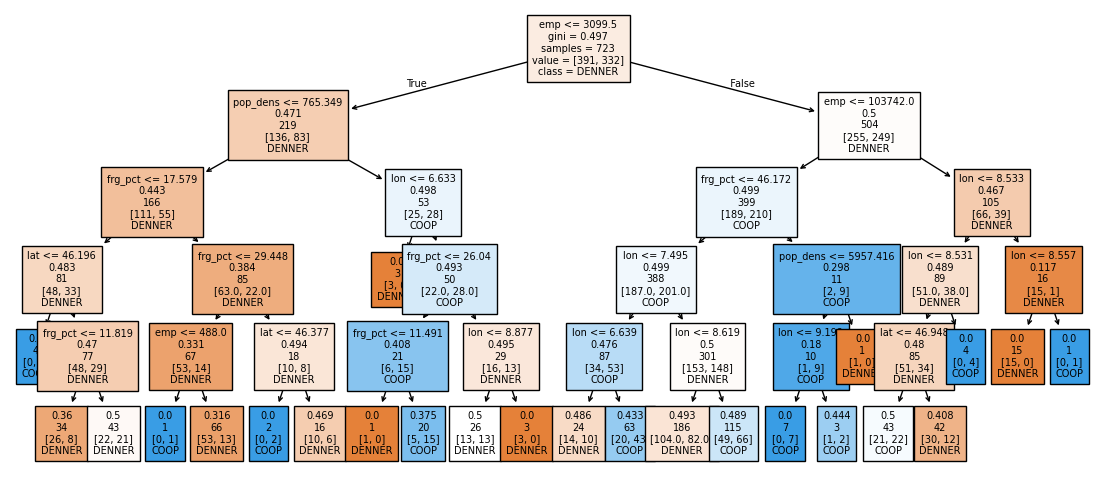

In [10]:
# feature_names=list(X_train.columns): Namen der unabhängigen Variablen
# class_names=['DENNER', 'COOP']: Namen der Zielvariablen
# filled=True: Füllung der Knoten, fontsize=7: Schriftgröße, label='root': Beschriftung des Wurzelknotens

# For the meaning of numbers in boxes see root node
fig = plt.figure(figsize=(14,6))
tree_plot = tree.plot_tree(clf, 
                   feature_names=list(X_train.columns),  
                   class_names=['DENNER', 'COOP'],
                   filled=True,
                   fontsize=7,
                   label='root')

## Random Forest Classifier
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [11]:
# Aufteilung in 2 Teile: nabhängigen Variablen (Features) und die abhängige Variable (Zielvariable)
# unabhänige Variablen: lat, lon, pop, pop_dens, frg_pct, emp
# train_test_split & test_size: Aufteilung in 80% Trainings- und 20% Testdaten
# random_state: Zufallszahlengenerator 5 reproduzierbar

# Create train and test samples
X2_train, X2_test, y2_train, y2_test = train_test_split(df_sub[['lat',
                                                                'lon',
                                                                'pop', 
                                                                'pop_dens', 
                                                                'frg_pct', 
                                                                'emp']],
                                                        df_sub['brand'], 
                                                        test_size=0.20, 
                                                        random_state=5)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
            lat       lon     pop     pop_dens    frg_pct       emp
1634  46.802091  9.835128   10862    38.246479  27.315412    8952.0
2756  46.787782  7.078202    1925   330.188679  20.779221    1295.0
3225  47.212596  7.496743    5284   998.865784  28.917487    2321.0
661   46.937092  7.386816  134591  2607.342115  24.862732  188252.0
2888  47.416141  9.267237   18108   658.233370  20.427435   13292.0 

y2_train:
1634    DENNER
2756    DENNER
3225      COOP
661     DENNER
2888    DENNER
Name: brand, dtype: object


### Fit the Random Forest Classifier

In [12]:
# n_estimators=500: Anzahl der Bäume im Wald, random_state=42: Zufallszahlengenerator reproduzierbar, max_depth=5: Tiefe des Baumes
# Trainieren des Random Forest Klassifikators mit rfc.fit(X2_train, y2_train)
# Vorhersage des Modells mit rfc.predict(X2_test)

# Initialize the random forest classifier
rfc = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=5)

# Train the classification tree model
rfc = rfc.fit(X2_train, y2_train)

# Predict the target variable
y_pred_rf = rfc.predict(X2_test)

# Crosstab
print('Brand versus predicted brand:', '\n')
df_pred = pd.DataFrame(data={'brand': y2_test, 
                             'brand_predicted': y_pred_rf}).reset_index(drop=True)
df_pred

Brand versus predicted brand: 



,brand,brand_predicted
0,COOP,DENNER
1,DENNER,DENNER
2,DENNER,COOP
3,DENNER,DENNER
4,DENNER,COOP
...,...,...
176,COOP,DENNER
177,DENNER,COOP
178,DENNER,COOP
179,COOP,COOP


### Show confusion matrix and classification report

In [13]:
# Vergleich der Testdaten mit den Vorhersagen des Modells
# Confusion Matrix: 4x4 Matrix mit den Werten True Positive, True Negative, False Positive und False Negative

# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y2_test, y_pred_rf), '\n')

# Precision: Anteil der korrekt positiven Vorhersagen an allen positiven Vorhersagen
# Recall: Anteil der korrekt positiven Vorhersagen an allen tatsächlich positiven Werten
# F1-Score: Mittelwert aus Precision und Recall
# Support: Anzahl der tatsächlichen Werte

# Classification report
print('Classification report')
print(classification_report(y2_test, y_pred_rf))

Confusion matrix
[[59 44]
 [50 28]] 

Classification report
              precision    recall  f1-score   support

        COOP       0.54      0.57      0.56       103
      DENNER       0.39      0.36      0.37        78

    accuracy                           0.48       181
   macro avg       0.47      0.47      0.46       181
weighted avg       0.48      0.48      0.48       181



### Show feature importance

Index(['lat', 'lon', 'emp', 'pop_dens', 'pop', 'frg_pct'], dtype='object')
[0.26194282 0.22867783 0.13778921 0.13177211 0.12825992 0.11155812]


<Axes: ylabel='features'>

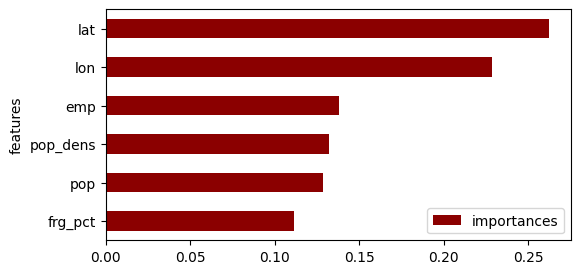

In [14]:
# Speichern der Spaltennamen aus X2_train in cols, LEDIGLICH Trainingsdaten anpassen??
cols = X2_train.columns

# Derive feature importance from the random forest classifier
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

### ROC curve and AUC

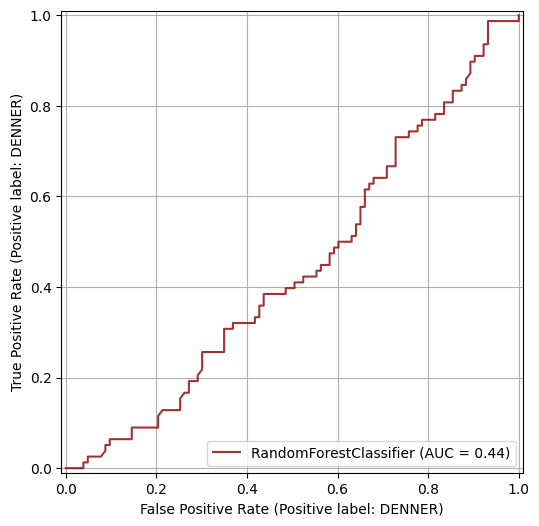

In [15]:
# rfc: Random Forest Klassifikator, X2_test: Testdaten, y2_test: Zielvariable, 
# ax: Achse, alpha: Transparenz, c: Farbe, plt.grid(): Gitternetzlinien

# Plot ROC curve and calculate AUC
plt.figure(figsize=(6,6))
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, 
                                          X2_test, 
                                          y2_test, 
                                          ax=ax,
                                          alpha=0.8,
                                          c="darkred")
plt.grid()
plt.show()

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [16]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2024-11-10 10:27:47
Python Version: 3.11.10
-----------------------------------
